 # 変更点
- CustomerをLocationインスタンスの塊に変更
- insertion_locationを削除

# 問題例

## 問題例の作成

In [1]:
class TW():
    def __init__(self, s, e):
        """
        時間枠を表す構造体
            s : 時間枠の開始時刻
            e : 時間枠の終了時刻
        """
        self.s = s
        self.e = e

In [2]:
class Location():
    def __init__(self, number=None, coordinate=None, demand=None, loc_type=None, tw=TW(0,0), penalty=None, arrivetime=0, departuretime=0):
        """
        地点を表す構造体
            number : 顧客を表す数字
            coordinate : 地点の座標
            demand : 地点の需要
            loc_type : 地点のタイプ(デポ，ピックアップ，デリバリー)
            arr : 到着時刻
            dep : 出発時刻
            tw : 時間枠
            penalty : 時間枠の逸脱費用
        """
        self.number = number
        self.coordinate = coordinate
        self.demand = demand
        self.loc_type = loc_type
        self.arr = arrivetime
        self.dep = departuretime
        self.tw = tw
        self.penalty = penalty

In [3]:
class Customer():
    def __init__(self, number, dt, pickup_coordinate, delivery_coordinate, demand, tw, penalty, serviceperiod):
        """
        customer : 顧客　(顧客を表す数字, 需要が発生する時刻, 需要量, ピックアップ地点を表す座標, デリバリー地点を表す座標, 時間枠, 時間枠の逸脱費用, サービス可能時間)
            number : 顧客を表す数字
            dt : 需要が発生する時刻
            pickup : ピックアップ地点を表すLocationインスタンス
            delivery : デリバリー地点を表すLocationインスタンス
            penalty : 時間枠の逸脱費用
        """
        self.number = number
        self.dt = dt
        self.demand = demand
        self.pickup = Location(number, pickup_coordinate, -demand, "p", TW(0,serviceperiod))
        self.delivery = Location(number, delivery_coordinate, demand, "d", tw, penalty)
        self.penalty = penalty

In [4]:
class Piecewiseinterval():
    def __init__(self, interval):
        """
        区分を表す構造体
            start : 区分の開始時刻
            end : 区分の終了時刻
        """
        self.start = interval[0]
        self.end = interval[1]

In [5]:
class Capacityfunctype():
    def __init__(self, capacities, intervals):
        self.capacities = capacities
        self.intervals = [Piecewiseinterval(i) for i in intervals]

In [6]:
class Capacity():
    def __init__(self, capacities=[0], intervals=[(0,0)]):
        """
        車両の容量を表す区分線形関数を表す構造体
            capacities : ある時刻での車両の容量を要素に持つリスト
            intervals : 時間の間隔を要素にもつリスト
        """
        #self.func = Capacityfunctype((0,), [(0, 0)])
        self.capacities = capacities
        self.intervals = intervals
    def setfunc(self, capacities, intervals):
        """
        与えられたcapacities(タプル)とpiecewiseintervals(タプル)を元にして，新たに関数を定義する
        """
        #self.func = Capacityfunctype(capacities, intervals)
        self.capacities = capacities
        self.intervals = [Piecewiseinterval(i) for i in intervals]
    def getfuncval(self, x):
        """
        ある時刻xでの関数の値を所得する
        """
        #for i, t in enumerate(self.func.intervals):
            #if t.start <= x <= t.end:
                #return self.func.capacity[i]
        for i, t in zip(self.capacities, self.intervals):
            if t.start <= x <= t.end:
                return i

In [7]:
class Currnetlocation():
    def __init__(self, customer_idx, coordinate):
        """
        車両の現在位置を表す構造体
        """
        self.idx = customer_idx
        self.coordinate = coordinate

In [8]:
class Vehicle():
    def __init__(self, number, capacity, tour):
        """
        vehicles : 配送車 (配送車を表す数字, 容量, 巡回路)
            number : 配送車を表す数字
            capacity : 容量
            tour : 巡回路
            currentlocation : 現在地
        """
        self.number = number
        self.capacity = Capacity()
        self.tour = tour
        self.currentlocation = Location(-1, (0,0))#Currnetlocation((0, 0), -1) # 最初はデポから出発 & 最後はデポに帰る

In [9]:
class Instance():
    def __init__(self):
        """
        service_period : 全体の勤務時間
        customers : 客の集合
        vehicles : 配送車の集合
        """
        self.service_period = 0
        self.customers = []
        self.vehicles = []
    def example(self):
        """
        parameters :
            n : 顧客の数
            r : 顧客の座標の範囲
            dt : 需要が発生する時刻
            lower_dem : 需要量の最小値
            upper_dem : 需要量の最大値
            demand : 需要量
            tw : 顧客の時間枠
            penalty : 時間枠の逸脱費用
            n_vehicles : 配送車の数
            lower_cap : 配送車の容量の最小値
            upper_cap : 配送車の容量の最大値
            capacity : 配送車の容量
            tour : 巡回路
        """
        import random
        random.seed(0)
        self.service_period = 30
        n = 3
        r = 10.0
        lower_dem = 1
        upper_dem = 10
        demands = 0
        for i in range(n):
            dt = random.randint(0, int(self.service_period*0.7))
            demand = random.uniform(lower_dem, upper_dem)
            p_x = random.uniform(-r, r)
            p_y = random.uniform(-r, r)
            d_x = random.uniform(-r, r)
            d_y = random.uniform(-r, r)
            s = random.uniform(0, self.service_period)
            e = random.uniform(s, self.service_period)
            tw = TW(s,e)
            penalty = 0.1
            c = Customer(i, dt, (p_x, p_y), (d_x, d_y), demand, tw, penalty, self.service_period)
            self.customers.append(c)
            demands += demand
        n_vehicles = random.randint(1, n)
        lower_cap = demands/2
        upper_cap = demands
        for v in range(n_vehicles):
            capacity = random.uniform(lower_cap, upper_cap)
            #upper_cap = demands - capacity
            depot = Location(-1, (0,0), 0, "depot")
            tour = [depot, depot]
            #plan = [(0,0), (self.service_period,)]
            v = Vehicle(v, capacity, tour)
            v.capacity.setfunc([capacity], [(0, self.service_period)])
            self.vehicles.append(v)

In [10]:
instance = Instance()
instance.example()

In [11]:
print("全体の時間 : ", instance.service_period, "分")
print("顧客 : ")
for c in instance.customers:
    for var in vars(c):
        print("\t", var, " :", eval("c."+str(var)))
    print()
print("車両 : ")
for v in instance.vehicles:
    for var in vars(v):
        print("\t", var, " :\t", eval("v."+str(var)))
    print()

全体の時間 :  30 分
顧客 : 
	 number  : 0
	 dt  : 12
	 demand  : 7.821589626462722
	 pickup  : <__main__.Location object at 0x7ff410d4c590>
	 delivery  : <__main__.Location object at 0x7ff40ff4ac10>
	 penalty  : 0.1

	 number  : 1
	 dt  : 15
	 demand  : 4.222444372254895
	 pickup  : <__main__.Location object at 0x7ff410d4ca10>
	 delivery  : <__main__.Location object at 0x7ff410d4c610>
	 penalty  : 0.1

	 number  : 2
	 dt  : 17
	 demand  : 9.845069284338878
	 pickup  : <__main__.Location object at 0x7ff410d4cad0>
	 delivery  : <__main__.Location object at 0x7ff410d4c2d0>
	 penalty  : 0.1

車両 : 
	 number  :	 0
	 capacity  :	 <__main__.Capacity object at 0x7ff410d4c7d0>
	 tour  :	 [<__main__.Location object at 0x7ff410d4c1d0>, <__main__.Location object at 0x7ff410d4c1d0>]
	 currentlocation  :	 <__main__.Location object at 0x7ff410c844d0>

	 number  :	 1
	 capacity  :	 <__main__.Capacity object at 0x7ff410d64890>
	 tour  :	 [<__main__.Location object at 0x7ff410d4c4d0>, <__main__.Location object a

In [12]:
#顧客の需要の合計 < 配送車の容量の合計　となっているかチェック
print(
    sum(eval("c."+str(var)+".demand") for var in vars(c) for c in instance.customers if var=="pickup")
      <=
    sum(eval("v."+str(var) +".capacities[0]")  for var in vars(v) for v in instance.vehicles if var=="capacity")
)
#sum(map(lambda x : x[1], customers.values())) <= sum(map(lambda x : x[0], vehicles.values()))

True


## 問題例の描画

あるリクエストに対し，●がピックアップ地点，▲がデリバリー地点


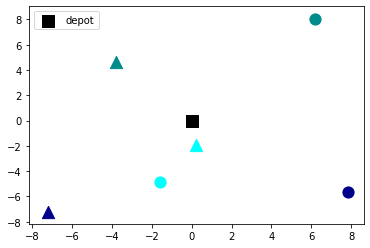

In [13]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# 顧客の情報の展開
p, d = [], []
for c in instance.customers:
    for var in vars(c):
        if var == "pickup":
            p.append(eval("c."+str(var)+".coordinate"))
        elif var == "delivery":
            d.append(eval("c."+str(var)+".coordinate"))
p_xs, p_ys = zip(*p)
d_xs, d_ys = zip(*d)

# 顧客の色の選択と，デポの描画
colors =  list(matplotlib.colors.cnames.keys())
plt.scatter(0, 0, marker=",", color="black", s=150, label="depot")

for i in range(len(instance.customers)):
    color = colors[i+20]
    p_x, p_y, d_x, d_y = p_xs[i], p_ys[i], d_xs[i], d_ys[i]
    # ピックアップ地点
    plt.scatter(p_x, p_y, marker=".", color=color, s=500)
    # デリバリー地点
    plt.scatter(d_x, d_y, marker="^", color=color, s=150)

# 顧客の描画
print("あるリクエストに対し，●がピックアップ地点，▲がデリバリー地点")
plt.legend()
plt.show()

# 問題を解く

## 配送計画

### 1. Constructive method

- Constructive methodでは，i分ごとにCheapest insertion methodを行う．
- Cheapest insertion methodでは，tourにリクエストを挿入するのにかかるコストを元に，現在のtourにリクエストを挿入する．
- リクエストをスラックタイムの少ない順に並べてから挿入を行う．
- コストはそのリクエストを挿入することによっておこるルートの増加量とスラックタイムの減少量を元に算出する．

### 2. Local Search

- LS

## スケジューリング

### Drive first strategy
- なるはやで行く．
- 客のところで待つのも可．

In [139]:
class Methods():
    def __init__(self):
        self.velocity = 1
        self.alpha = 0.1
        self.beta = 1.0
        self.gamma = 1.0
    def set_var(self, instance):
        self.service_period = instance.service_period
        self.customers = instance.customers
        self.vehicles = instance.vehicles
    def solve(self):
        """
        i分ごとに実行可能解を作る．（Cheapest insertion methodを行う + DFを行う．）
        parameters :
            i : Cheapest insertion methodを行う時間間隔（整数）
        """
        # 需要が発生する時刻が早い順に並べ替える
        self.sorted_cs = sorted(self.customers, key=lambda customer : customer.dt)
        # i分ごとにconstructiveを実行
        i = 5
        self.time = sorted(set(range(0, self.service_period, i))|{self.service_period})
        self.now = -1
        while (self.sorted_cs != []) and (len(self.sorted_cs) != 0):
            self.now += 1
            # 前回挿入を行った時から現在までの間に溜まったリクエストを計算
            self.heapup_reqs()
            # Cheapest insertionの実行
            self.constructive()
    def heapup_reqs(self):
        """
        前回挿入を行った時から現在までの間に溜まったリクエストを計算
        """
        self.new_reqs = []
        for idx, customer in enumerate(self.sorted_cs):
            if customer.dt <= self.time[self.now]:
                self.new_reqs.append(customer)
                if idx == len(self.sorted_cs)-1:
                    self.sorted_cs = []
            else:
                self.sorted_cs = self.sorted_cs[idx:]
                break
    def constructive(self):
        """
        Cheapest insertion methos : tourを前から順番に見ていき,最も挿入するコストがかからないところにリクエストを挿入
        variables :
            #insertion_locations : リクエストをtourに挿入する場所の辞書（keyが顧客の番号，valueが挿入する場所）
        """
        if self.new_reqs != []:
            # tourを前から順番に見ていき，最も挿入するコストがかからないところを見つける
            # 各車両のtourにリクエストを挿入
            self.insert()
    def insert(self):
        """
        新しいリクエストたち(new_reqs)を挿入する場所を決め,tourに挿入する
        新しいリクエストの発着時間を決める
        variables :
            min_cost_p, min_cost_d : あるリクエストを巡回路に挿入するときに便宜上必要なコスト
        """
        # 新しいリクエストを順番に見ていく
        for new_req in self.new_reqs:
            print("\033[31m" + "insert start" + "\033[0m")
            print(f"顧客{new_req.number}を挿入")
            # 挿入場所の決定
            self.decide_insertionpoint(new_req)
            # tourに，新しいリクエストたち(new_reqs)のLocationインスタンス(Customerインスタンスをピックアップとデリバリーに分解したもの)を挿入する
            print(f"顧客{new_req.number}は，車両{self.vehicle_n}が訪問する(巡回路の{self.point_p}番目と{self.point_d}番目に挿入)")
            self.update_tour(new_req)
            # DFの実行
            self.DF(self.vehicles[self.vehicle_n], new_req)
            print("\033[31m" + "insert end\n" + "\033[0m")
    def decide_insertionpoint(self, new_req):
        self.vehicle_n = 0
        self.point_p, self.point_d = 0, 0
        self.cost_p, self.cost_d = 0, 0
        self.min_cost_p, self.min_cost_d = 1e+10, 1e+10
        flag = True
        v = 0
        # 各車両を順番に見ていく
        #for v in range(len(self.vehicles)):
        while flag:
            flag = True
            vehicle = self.vehicles[v]
            v += 1
            # 車両vehicleのtour
            v_tour, now_idx = self.traverse_tour(vehicle, self.time[self.now])
            print(f"\t{vehicle.number}の巡回路は，{[l.number for l in v_tour]}")
            for idx, location in enumerate(v_tour[:-1]):
                nextlocation = v_tour[idx+1]
                # コストの計算
                self.calculate_cost(new_req, vehicle, location.coordinate, nextlocation.coordinate)
                print(f"\t\t車両{self.vehicle_n}の{idx}番目に挿入するのにかかるコストは，ピックアップ : {self.cost_p}, デリバリー : {self.cost_d}\n")
                # 挿入位置，暫定最小コストの更新
                self.update_mincost(vehicle, idx, now_idx)
                if self.min_cost_p < 1e+100 and self.min_cost_d < 1e+100:
                    flag = False
                    v = 0
                    break
        assert self.point_p <= self.point_d, f"ピックアップよりも前にデリバリーされている． ピックアップ : {self.point_p}, デリバリー : {self.point_d}"
    def traverse_tour(self, vehicle, nowtime):
        """
        車両の現在地(self.currentlocation)よりも後にある顧客．つまり，まだ訪問していない顧客の配列を返す
        variables :
            now_idx : 
            tour_temp : 
        """
        traverse_tour = []
        now_idx = [i for i,loc in enumerate(vehicle.tour) if vehicle.currentlocation.number==loc.number][0]
        print("\t" + "\033[31m" + "traverse_tour start" + "\033[0m")
        print("\t現在時刻 : ", self.time[self.now])
        print("\t現在地(顧客の番号) : ", now_idx)
        tour_temp = vehicle.tour[now_idx:-2] if len(vehicle.tour)!=2 else vehicle.tour
        for i, previouslocation in enumerate(tour_temp):
            if previouslocation.dep <= nowtime:
                nextlocation = vehicle.tour[i+1]
                # 現在地の更新
                self.update_currentlocation(vehicle, i, nowtime, previouslocation, nextlocation)
                # traverse_tourに代入
                traverse_tour = [vehicle.currentlocation] + vehicle.tour[i:-1]
                break
        print("\t" + "\033[31m" + "traverse_tour end\n" + "\033[0m")
        return traverse_tour, now_idx
    def update_currentlocation(self, vehicle, i, nowtime, previouslocation, nextlocation):
        dx = nextlocation.coordinate[0]-previouslocation.coordinate[0] or 1
        dy = nextlocation.coordinate[1]-previouslocation.coordinate[1] or 1
        diagonal = (dx**2+dy**2)**(1/2) or 1
        x_per_min = dx/(self.velocity*(dx/diagonal))
        y_per_min = dy/(self.velocity*(dy/diagonal))
        vehicle.currentlocation.idx =  i
        vehicle.currentlocation.coordinate = (previouslocation.coordinate[0]+x_per_min*(nowtime - previouslocation.dep), previouslocation.coordinate[1]+y_per_min*(nowtime - previouslocation.dep))
    def calculate_cost(self, new_req, vehicle, location, nextlocation):
        self.cost_p = (1-self.alpha)*self.f(location, new_req.pickup.coordinate, nextlocation) + self.alpha*self.g(new_req.pickup.coordinate, new_req.delivery.coordinate) + self.beta*self.h(vehicle.capacity.getfuncval(self.time[self.now]), new_req.demand)
        self.cost_d = (1-self.alpha)*self.f(location, new_req.delivery.coordinate, nextlocation) + self.alpha*self.g(new_req.pickup.coordinate, new_req.delivery.coordinate) + self.gamma*self.i(location, new_req)
    def update_mincost(self, vehicle, idx, now_idx):
        if self.cost_p < self.min_cost_p:
            self.min_cost_p = self.cost_p
            self.point_p = idx + (now_idx or 1)
            self.vehicle_n = vehicle.number
        if (self.cost_d < self.min_cost_d):# and (self.point_p <= self.point_d):
            self.min_cost_d = self.cost_p
            self.point_d = idx + (now_idx or 1) + (self.point_p==1)
            self.vehicle_n = vehicle.number
    def f(self, location, new_location, nextlocation):
        """
        巡回路の距離の増加を計算する
        locationとnew_locationのユークリッド距離 + new_locationとlocation+1のユークリッド距離
        """
        return self.distance(location, new_location) + self.distance(new_location, nextlocation)
    def distance(self, p, q):
        return ((p[0]-q[0])**2+(p[1]-q[1])**2)**(1/2)
    def g(self, p, d):
        """
        スラックタイムの減少を計算する
        サービス可能時間 - ピックアップ地点からデリバリー地点へ直接移動するのにかかる時間
        """
        slacktime = 0
        return slacktime - self.distance(p, d)/self.velocity
    def h(self, capacity, demand):
        """
        車両の容量制約が満たされているか判断する
        parameters :
            違反した場合に返す値
        """
        if demand > capacity:
            return 1e+100
        return 0
    def i(self, alocintour, new_req):
        """
        時間枠の違反度を計算する
        tour内の地点を出発する時刻 + tour内の地点からリクエストのデリバリー地点までにかかる時間 <= 顧客の時間枠の締め切り時刻　→　ペナルティ 0
        それ以外　→ ペナルティ (顧客の時間枠の締め切り時刻 - tour内の地点からリクエストのデリバリー地点までにかかる時間)*そのリクエストの時間枠違反にかかる単位時間あたりコスト
        """
        overtime = new_req.delivery.tw.e - self.distance(alocintour, new_req.delivery.coordinate)
        penalty = 0
        if overtime > 0:
            penalty = overtime*new_req.penalty
        return penalty
    def update_tour(self, new_req):
        """
        tourにリクエストのピックアップ地点，デリバリー地点を追加
        """
        idx_p, idx_d = self.point_p, self.point_d
        tour = self.vehicles[self.vehicle_n].tour
        print("\033[31m" + "update_tour start" + "\033[0m")
        print(f"車両{self.vehicle_n}の巡回路は{[(l.number, l.loc_type) for l in tour]}")
        self.vehicles[self.vehicle_n].tour = tour[:idx_p] + [new_req.pickup] + tour[idx_p:idx_d-1] + [new_req.delivery] + (tour[idx_d-1:] or [tour[-1]])
        print(f"車両{self.vehicle_n}の巡回路は{[(l.number, l.loc_type) for l in self.vehicles[self.vehicle_n].tour]}")
        print("\033[31m" + "update_tour end\n" + "\033[0m")
    def DF(self, vehicle, new_req):
        """
        各車両の巡回路(tour)から顧客の発着時間を決定
        巡回路に新たなリクエストが入れられた車両の容量を減らす
        """
        print("\033[31m" + "DF start" + "\033[0m")
        print(f"{new_req.number}の発着時刻を決める")
        print(f"車両{self.vehicle_n}の巡回路は{[(l.number, l.loc_type) for l in vehicle.tour]}")
        # 発着時間の決定
        for i, now in enumerate(vehicle.tour):
            if i != 0:
                prev = vehicle.tour[i-1]
                #print(f"prev : {prev.number}")
                now.arr = prev.dep + self.distance(prev.coordinate, now.coordinate)
                print(f"\t{(now.number, now.loc_type)}の到着時刻 : {now.arr}")
                print(f"\t{(now.number, now.loc_type)}の時間枠の始まり : {now.tw.s}")
                print(f"\t時間枠よりも前に着いた : {((now.tw.s-now.arr)>0)}")
                now.dep = now.arr + (now.tw.s-now.arr)*((now.tw.s-now.arr)>0)#時間枠の始まりよりも前に着いたら待機
                print(f"\t{(now.number, now.loc_type)}の出発時刻 : {now.dep}\n")
        # 車両の容量を減らす
        # self.vehicles[self.vehicle_n].tour[self.point_p].depからself.vehicles[self.vehicle_n].tour[self.point_d].arrまでの間の車両の容量を減らす
        self.modifycapacity(new_req)
        print("\033[31m" + "DF end" + "\033[0m")
    def modifycapacity(self, new_req):
        """
        車両の容量を表す区分線形関数に変更を加える．
        """
        print(f"ピックアップ地点 : {(self.vehicles[self.vehicle_n].tour[self.point_p].number, self.vehicles[self.vehicle_n].tour[self.point_p].loc_type)}")
        s, e = self.vehicles[self.vehicle_n].tour[self.point_p].dep, self.vehicles[self.vehicle_n].tour[self.point_d].arr
        print(f"車両{self.vehicle_n}の容量を{s}から{e}まで{new_req.demand}減らす")
        capacities, intervals = self.vehicles[self.vehicle_n].capacity.capacities, [(i.start, i.end) for i in self.vehicles[self.vehicle_n].capacity.intervals]
        flag = False
        for i in range(len(capacities)-1):
            if intervals[i].start <= s <= intervals[i].end:
                flag = True
                del intervals[i]
                intervals = intervals[:i+1] + [(intervals[i].start, s)] + [(s, intervals[i].end)] + intervals[i+1:]
                capacities = capacities[:i+1] + [capacities[i]-new_req.demand] + capacities[i+1:]
            elif capacities[i].start <= e <= capacities[i].end:
                flag = False
                del intervals[i]
                intervals = intervals[:i+1] + [(intervals[i].start, e)] + [(e, intervals[i].end)] + intervals[i+1:]
                capacities = capacities[:i+1] + [capacities[i]-new_req.demand] + capacities[i+1:]
            if flag:
                capacities[i] -= new_req.demand
        self.vehicles[self.vehicle_n].capacity.setfunc(capacities, intervals)
        
        

In [140]:
instance = Instance()
instance.example()

In [141]:
methods = Methods()
methods.set_var(instance)
print(methods.service_period)

30


In [142]:
methods.solve()

insert start
顧客0を挿入
	traverse_tour start
	現在時刻 :  15
	現在地(顧客の番号) :  0
	traverse_tour end

	0の巡回路は，[-1, -1]
		車両0の0番目に挿入するのにかかるコストは，ピックアップ : 35.37264022431821, デリバリー : 29.478490632939163

顧客0は，車両0が訪問する(巡回路の1番目と2番目に挿入)
update_tour start
車両0の巡回路は[(-1, 'depot'), (-1, 'depot')]
車両0の巡回路は[(-1, 'depot'), (0, 'p'), (0, 'd'), (-1, 'depot')]
update_tour end

DF start
0の発着時刻を決める
車両0の巡回路は[(-1, 'depot'), (0, 'p'), (0, 'd'), (-1, 'depot')]
	(0, 'p')の到着時刻 : 5.0766133223248895
	(0, 'p')の時間枠の始まり : 0
	時間枠よりも前に着いた : False
	(0, 'p')の出発時刻 : 5.0766133223248895

	(0, 'd')の到着時刻 : 8.514527635143184
	(0, 'd')の時間枠の始まり : 23.51395767104318
	時間枠よりも前に着いた : True
	(0, 'd')の出発時刻 : 23.51395767104318

	(-1, 'depot')の到着時刻 : 25.42859994198953
	(-1, 'depot')の時間枠の始まり : 0
	時間枠よりも前に着いた : False
	(-1, 'depot')の出発時刻 : 25.42859994198953

ピックアップ地点 : (0, 'p')
車両0の容量を5.0766133223248895から8.514527635143184まで7.821589626462722減らす
DF end
insert end

insert start
顧客1を挿入
	traverse_tour start
	現在時刻 :  15
	現在地(顧客の番号) :  0
	traverse_tour end

	

In [25]:
print([[i.number for i in instance.vehicles[v].tour] for v in range(len(instance.vehicles))])

[[-1, 2, 2, -1], [-1, 0, 1, 1, 0, -1]]
